# Sentiment analysis with pretrained word vectors

In Chapter 15, Word Embeddings, we discussed how to learn domain-specific word embeddings. Word2vec, and related learning algorithms, produce high-quality word vectors, but require large datasets. Hence, it is common that research groups share word vectors trained on large datasets, similar to the weights for pretrained deep learning models that we encountered in the section on transfer learning in the previous chapter.

We are now going to illustrate how to use pretrained Global Vectors for Word Representation (GloVe) provided by the Stanford NLP group with the IMDB review dataset.

In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, concatenate, Embedding, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.backend as K

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)
K.clear_session()

## Load Reviews

We are going to load the IMDB dataset from the source for manual preprocessing.

Data source: [Stanford IMDB Reviews Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

In [3]:
path = Path('data/aclImdb/')

In [4]:
files = path.glob('**/*.txt')
len(list(files))

50000

In [5]:
files = path.glob('*/**/*.txt')
data = []
for f in files:
    _, _, data_set, outcome = str(f.parent).split('/')
    data.append([data_set, int(outcome=='pos'), f.read_text(encoding='latin1')])

In [6]:
data = pd.DataFrame(data, columns=['dataset', 'label', 'review']).sample(frac=1.0)

In [7]:
train_data = data.loc[data.dataset=='train', ['label', 'review']]
test_data = data.loc[data.dataset=='test', ['label', 'review']]

In [8]:
train_data.label.value_counts()

1    12500
0    12500
Name: label, dtype: int64

In [9]:
test_data.label.value_counts()

1    12500
0    12500
Name: label, dtype: int64

## Prepare Data

### Tokenizer

Keras provides a tokenizer that we use to convert the text documents to integer-encoded sequences, as shown here:

In [10]:
num_words = 10000
t = Tokenizer(num_words=num_words, 
              lower=True, 
              oov_token=2)
t.fit_on_texts(train_data.review)

In [11]:
vocab_size = len(t.word_index) + 1
vocab_size

88586

In [12]:
train_data_encoded = t.texts_to_sequences(train_data.review)
test_data_encoded = t.texts_to_sequences(test_data.review)

In [13]:
max_length = 100

### Pad Sequences

We also use the pad_sequences function to convert the list of lists (of unequal length) to stacked sets of padded and truncated arrays for both the train and test datasets:

In [14]:
X_train_padded = pad_sequences(train_data_encoded, 
                            maxlen=max_length, 
                            padding='post',
                           truncating='post')
y_train = train_data['label']
X_train_padded.shape

(25000, 100)

In [15]:
X_test_padded = pad_sequences(test_data_encoded, 
                            maxlen=max_length, 
                            padding='post',
                           truncating='post')
y_test = test_data['label']
X_test_padded.shape

(25000, 100)

## Load Embeddings

Assuming we have downloaded and unzipped the GloVe data to the location indicated in the code, we now create a dictionary that maps GloVe tokens to 100-dimensional real-valued vectors, as follows:

In [16]:
# load the whole embedding into memory
glove_path = Path('data/glove/glove.6B.100d.txt')
embeddings_index = dict()

for line in glove_path.open(encoding='latin1'):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except:
        continue
    embeddings_index[word] = coefs

In [17]:
print('Loaded {:,d} word vectors.'.format(len(embeddings_index)))

Loaded 399,883 word vectors.


There are around 340,000 word vectors that we use to create an embedding matrix that matches the vocabulary so that the RNN model can access embeddings by the token index:

In [18]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix.shape

(88586, 100)

## Define Model Architecture

The difference between this and the RNN setup in the previous example is that we are going to pass the embedding matrix to the embedding layer and set it to non-trainable, so that the weights remain fixed during training:

In [20]:
embedding_size = 100

In [21]:
rnn = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim= embedding_size, 
              input_length=max_length,
              weights=[embedding_matrix], 
              trainable=False),
    GRU(units=32,  dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          8858600   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 8,871,497
Trainable params: 12,897
Non-trainable params: 8,858,600
_________________________________________________________________


In [22]:
rnn.compile(loss='binary_crossentropy',
            optimizer='RMSProp',
            metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')])

In [23]:
early_stopping = EarlyStopping(monitor='val_AUC',
                               patience=5,
                               mode='max',
                               restore_best_weights=True)

In [24]:
training = rnn.fit(X_train_padded,
                  y_train,
                  batch_size=32,
                  epochs=100,
                  validation_data=(X_test_padded, y_test),
                  callbacks=[early_stopping],
                  verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 74s 3ms/sample - loss: 0.6499 - accuracy: 0.6072 - AUC: 0.6562 - val_loss: 0.5579 - val_accuracy: 0.7105 - val_AUC: 0.8105
Epoch 2/100
25000/25000 [==============================] - 73s 3ms/sample - loss: 0.5149 - accuracy: 0.7487 - AUC: 0.8244 - val_loss: 0.4586 - val_accuracy: 0.7806 - val_AUC: 0.8674
Epoch 3/100
25000/25000 [==============================] - 75s 3ms/sample - loss: 0.4696 - accuracy: 0.7774 - AUC: 0.8574 - val_loss: 0.4345 - val_accuracy: 0.7936 - val_AUC: 0.8814
Epoch 4/100
25000/25000 [==============================] - 73s 3ms/sample - loss: 0.4471 - accuracy: 0.7906 - AUC: 0.8721 - val_loss: 0.4250 - val_accuracy: 0.7984 - val_AUC: 0.8893
Epoch 5/100
25000/25000 [==============================] - 72s 3ms/sample - loss: 0.4334 - accuracy: 0.7982 - AUC: 0.8806 - val_loss: 0.4318 - val_accuracy: 0.7960 - val_AUC: 0.8939
Epoch 6/100
25000/25000 [===============

In [25]:
y_score = rnn.predict(X_test_padded)
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)

0.9109512512

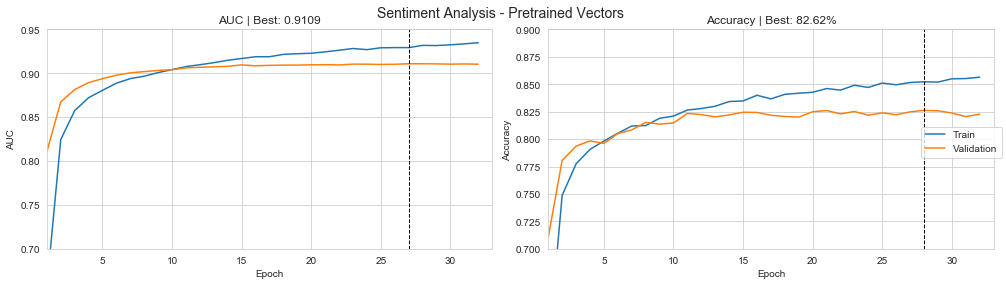

In [64]:
df = pd.DataFrame(training.history)
best_auc = df.val_AUC.max()
best_acc = df.val_accuracy.max()

fig, axes = plt.subplots(ncols=2, figsize=(14,4))
df.index = df.index.to_series().add(1)
df[['AUC', 'val_AUC']].plot(ax=axes[0], 
                            title=f'AUC | Best: {best_auc:.4f}', 
                            legend=False, 
                            xlim=(1, 33),
                            ylim=(.7, .95))

axes[0].axvline(df.val_AUC.idxmax(), ls='--', lw=1, c='k')
df[['accuracy', 'val_accuracy']].plot(ax=axes[1], 
                                              title=f'Accuracy | Best: {best_acc:.2%}', 
                                              legend=False, 
                                              xlim=(1, 33),
                                      ylim=(.7, .9))
axes[1].axvline(df.val_accuracy.idxmax(), ls='--', lw=1, c='k')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
fig.suptitle('Sentiment Analysis - Pretrained Vectors', fontsize=14)
fig.legend(['Train', 'Validation'], loc='center right')
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/imdb_pretrained', dpi=300);

In [27]:
df.to_csv('lstm_sa_pretrained.csv', index=False)